In [1]:
#default_exp meta.estimators

In [2]:
#hide
from nbdev.showdoc import *

# Meta Estimators

> A set of Meta Estimators suited for density estimation

- [ ] Understand sklearns StackedRegressor architecture

In [3]:
#export
import sklearn.ensemble as ensemble
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, normalize
import numpy as np
import dill

## MultiOutputRegressor - 

In [4]:
#export
from sklearn.multioutput import MultiOutputRegressor
class CustomMultiOutputRegressor(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = 10, weights = None):        
        PRECISA MUDAR ESSA LINHA, TENTAR AMOSTRAR POR INDICES result = np.array([estim.sample(X, sample_size = sample_size, weights = weights) for estim in self.estimators_])
        result = np.swapaxes(result,0,1)
        result = np.swapaxes(result,1,2)
        return result

## TransformedTarget Estimator -

In [5]:
#export
def TransformedTargetEstimator(estimator, transformer = QuantileTransformer(output_distribution = 'normal',n_quantiles = 100)):
    '''
    a meta estimator (factory) that transforms target and inverse transforms after predicting. the transform and inverse transform
    are handled internaly, so the outputs are in the same scale as the original target values
    '''
    
    if isinstance(transformer, type):
        raise ValueError('if not str, transformer must be an instance containing fit, transform and fit_transform methods')    
    
    class TransformedTargetEstimator(estimator):        
        
        def _handle_y_shape_in(self, y):
            if self.y_dim == 1:                
                return y.reshape(-1,1)
            else: 
                return y
        
        def _handle_y_shape_out(self, y):
            if self.y_dim == 1:                
                return y.flatten()
            else: 
                return y
        
        def _fit_transformer(self, y):            
            self.y_dim = len(y.shape)
            y = self._handle_y_shape_in(y)
            self.transformer = transformer.fit(y)
            return self
        
        def _transform_transformer(self, y):
            y = self._handle_y_shape_in(y)
            y = self.transformer.transform(y)
            y = self._handle_y_shape_out(y)
            return y
        
        def _inverse_transform_transformer(self, y):
            y = self._handle_y_shape_in(y)
            y = self.transformer.inverse_transform(y)
            y = self._handle_y_shape_out(y)
            return y
        
        def fit(self, X, y = None):            
            self._fit_transformer(y)                        
            y = self._transform_transformer(y)
            super().fit(X, y)
            return self

        def transform(self,X):
            return self._inverse_transform_transformer(super().transform(X))
            
        def predict(self,X):
            return self._inverse_transform_transformer(super().predict(X))
        
        def fit_transform(self,X, y = None):            
            self.fit(X, y)            
            return self.transform(X)
        
        def fit_predict(self,X, y = None):            
            self.fit(X, y)            
            return self.predict(X)
    
    
    return TransformedTargetEstimator

We will create a bimodal dataset for exemplification

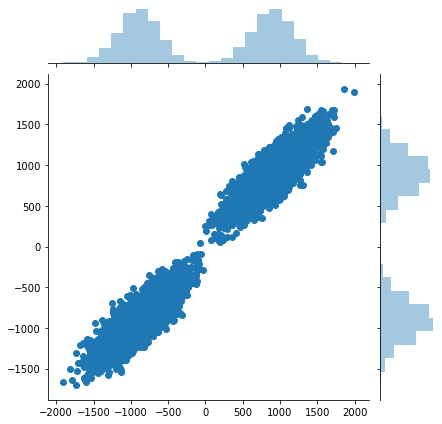

In [6]:
from sklearn.datasets import make_regression
import seaborn as sns

X,y = make_regression(
    n_samples=10000,
    n_features=30,
    n_informative=15,
    n_targets=2,
    bias=900,
    effective_rank=None,
    tail_strength=2,
    noise=0.2,
    shuffle=True,
    coef=False,
    random_state=None
)

bimodal_msk = np.random.randint(0,2,y.shape[0]).astype(bool)

y[bimodal_msk] = -abs(y[bimodal_msk])


#sns.distplot(y)
sns.jointplot(y[:,0],y[:,1])

X_train, X_test = X[:8000], X[8000:]
y_train, y_test = y[:8000], y[8000:]

You can create an estimator that performs Normlization during fit and inverse transforms the result during inferencce

In [7]:
from sklearn.linear_model import LinearRegression

TransformedTargetEstimator(LinearRegression)().fit_predict(X_train, y_train)

array([[-278.59411738,  350.28386453],
       [ 397.97407895,  433.59932116],
       [-186.44723216, -365.51766798],
       ...,
       [-321.31306604, -406.05520147],
       [-424.57846312, -516.5814212 ],
       [ 104.76912719,  -97.37079303]])

## Bagging Estimator - 

In [105]:
#export
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return np.array([estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features)])

class BaggingDensityEstimator(ensemble.BaggingRegressor):
    def sample(self, X, sample_size = None, weights = None):
        
        ensemble._bagging.check_is_fitted(self)
        # Check data
        X = ensemble._bagging.check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        # Parallel loop
        n_jobs, n_estimators, starts = ensemble._bagging._partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_y_hat = ensemble._bagging.Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            ensemble._bagging.delayed(_parallel_predict_regression)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        if sample_size is None:            
            return np.swapaxes(all_y_hat[0], 0, 1)
        else:
            samples = np.swapaxes(all_y_hat[0], 0, 1)
            samples_list = []
            for i in range(samples.shape[0]):
                idxs = np.random.choice([*range(samples.shape[1])], size = sample_size, p = weights)
                samples_list.append(samples[i,idxs])
            return np.array(samples_list)
            

The BaggingDensityEstimator is an extension of sklearn BaggingRegressor that allows sampling from each isntance of base estimator. We can bag Linear Regressors for example

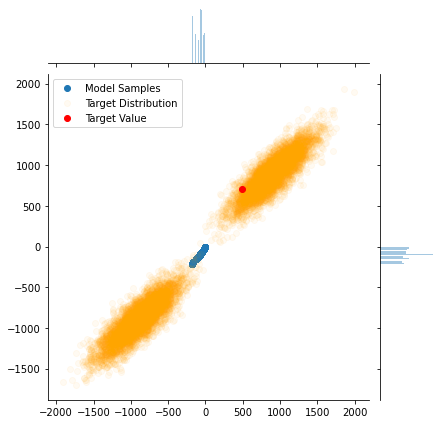

In [9]:
estimator = LinearRegression()
density_estimator = BaggingDensityEstimator(estimator, n_estimators = 10).fit(X,y)

samples = density_estimator.sample(X_test[0:1], sample_size = 1000)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples'})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

We can combine the TransformedTargetEstimator

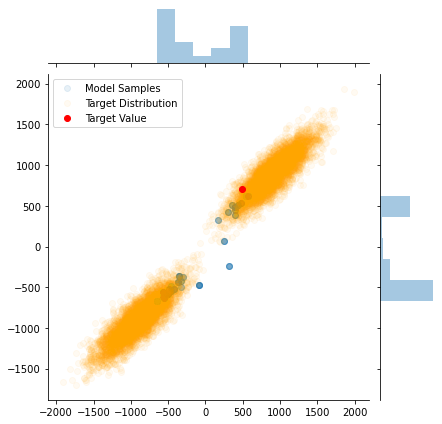

In [10]:
estimator = TransformedTargetEstimator(LinearRegression)()
density_estiamtor = BaggingDensityEstimator(estimator, n_estimators = 30, max_samples = 0.2,max_features = 0.2).fit(X,y)

samples = density_estiamtor.sample(X_test[0:1], sample_size = 300)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

## ADABoost Estimator -

In [106]:
#export
class AdaBoostDensityEstiamtor(ensemble.AdaBoostRegressor):
    
    def sample(self, X, sample_size = 10, weights = 'boosting_weights'):
        '''Sample according to estimator weights'''        
        
        
        predictions = np.array([
            est.predict(X) for est in self.estimators_[:len(self.estimators_)]]).T
        
        if weights is None:
            weights = np.ones(sample_size)[:len(self.estimators_)]
            weights /= weights.sum()
            
        elif weights == 'boosting_weights':
            weights = self.estimator_weights_[:len(self.estimators_)]
            weights /= weights.sum()            
        else:
            weights = self.estimator_weights_[:len(self.estimators_)]*weights
            weights /= weights.sum()
        
            
        samples = [np.random.choice(predictions[i].flatten(), size = sample_size, p = weights) for i in range(predictions.shape[0])]
        return np.array(samples)

AdaBoostDensityEstimator suports only single output tasks. you can use CustomMultiOutputRegressor, but since it will fit each output dimension separetly, you can get bad sampling results depending on the problem

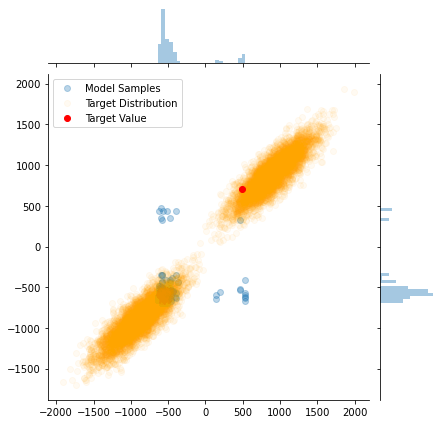

In [13]:
estimator = AdaBoostDensityEstiamtor(TransformedTargetEstimator(LinearRegression)(), learning_rate = 0.01)
multioutput_estimator = CustomMultiOutputRegressor(estimator)
density_estimator = multioutput_estimator.fit(X_train, y_train)

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.3})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

## Stacked Estimator -

> Allows for stacking while making the input of last layer as a sample of last estimators samples

In [107]:
from functools import partial


AVALIBLE_STACKING_METHODS = {
    'pdf_sample':'_fit_sample_pdf',
    'pdf_params':'_fit_getparams_pdf',
    'empirical_sample':'_empirical_sample'
}
        

    
def StackingChildFactory(estimator, stack_method = 'empirical_sample', stack_method_kwargs = dict(dist = None, sample_size = 10)):
    
    class StackingChildEstimator(estimator.__class__):

        def __init__(self, stack_method, sample_size = 30, weights = None, method_kwargs = {}):            
            super().__init__(**estimator.get_params())
            self._sample_size = sample_size
            self.weights = weights
            self.stack_method = _handle_stack_method(self, stack_method, **stacking_method_kwargs)
        
        def _handle_stack_method(self, stack_method, **method_kwargs):
            if stack_method.__class__ == str:
                return partial(getattr(self,stack_method), **method_kwargs)
            else:
                return partial(stack_method, **method_kwargs)
        
        def _apply_stacking_methods(self, stacking_method, X, sample_size = 30, weights = None):
            
            '''
            A method that recieves X as input and returns the "y" values that will be passed to
            the next layer.
            custom methods are applied to sampled values from estimator
            '''
            data = self.sample(X, sample_size = sample_size, weights = weights)
            getattr(self, stacking_method)()
            return y
        
        def _fit_sample_pdf(self, data, dist, sample_size):
            pdf = RandomVariable(data).fit_dist(dist)
        return pdf.rvs(sample_size).data.flatten()

        def _fit_getparams_pdf(self, data, dist, sample_size):
            pdf = RandomVariable(data).fit_dist(dist)
            return pdf.params.data.flatten()

        def _empirical_sample(self, data, dist, sample_size):
            '''dist here are the sample weights'''
            dist /= dist.sum()
            return np.random.choice(data, size = sample_size, p = dist)

        
    return StackingChildEstimator
        
        
def StackingDensityEstimator(stack_method = 'empirical_sample', stack_method_kwargs = dict(dist = None, sample_size = 10)):
    
    stack_method_name = stack_method
    
    class StackingDensityEstimator(ensemble.StackingRegressor):
        
        def _handle_stack_method(self, stack_method, **method_kwargs):
            if stack_method.__class__ == str:
                return partial(AVALIBLE_STACKING_METHODS[stack_method], **method_kwargs)
            else:
                return partial(stack_method, **method_kwargs)

        def fit(self, X, y = None):
            
            stack_method = self._handle_stack_method(stack_method_name,**stack_method_kwargs)
            for est in self.estimators:
                setattr(est[1], '_default_stacking_methods', stack_method)
                print(est[1]._default_stacking_methods)
            self.stack_method = '_default_stacking_methods'
            super().fit(X,y)
            return self 
    
    return StackingDensityEstimator

class StackingDensityEstimator(ensemble.StackingRegressor):
    def _sample_from_child(self,X):
        '''
        Instead of recieving the prediction of last estimator, it recieves a sumsample of each one of last estimators.
        child estimators contaion a sample method        
        '''
        pass
    
    def  _concatenate_children_output(self, outputs): 
        '''
        Concatenates the children samples 
        '''
        pass
    
    def _set_prior_to_sample():
        '''
        Instead of sampling from data, fit a disstribution  through MLE to data and sample from prior distribution.
        Like in variational auto encoders.
        '''
        pass
    
    def _pass_dist_parameters_instead_of_samples():
        '''
        instead of passing samples to next layer, pass distribution parameters found through MLE
        '''
        pass
    def _apply_method(X):
        '''
        Applies a generic method in the output stacking layer taking X from the stacking pipeline as argument.
        allows sample method and apply method for trees
        '''
        pass
    
    #NO NEED FOR SAMPLE METHOD SINCE IT WILL IMPLEMENT THE LAST LAYYER METHODS

SyntaxError: invalid syntax (<ipython-input-107-c77bbbea5356>, line 20)

In [76]:
t = StackingDensityEstimator()
e1 = BaggingDensityEstimator(TransformedTargetEstimator(LinearRegression)(), n_estimators = 10, max_samples = 0.2,max_features = 0.2).fit(X,y)
e2 = BaggingDensityEstimator(LinearRegression(), n_estimators = 10).fit(X,y)

t([('e1',e1),('e2',e2)],e1).fit(X_train,y_train[:,1])

functools.partial(<function _empirical_sample at 0x0000022B61C010D8>, dist=None, sample_size=10)
functools.partial(<function _empirical_sample at 0x0000022B61C010D8>, dist=None, sample_size=10)


AttributeError: 'BaggingDensityEstimator' object has no attribute '_default_stacking_methods'

In [ ]:
PASS SELF AS A FUNC PARAMETER AND MAKE IT WORK WHEN FUNCTIONS PASSED INSTEAD OF METHODS

## Voting Estimator - 

> creates an ensemble of diverse estimators (this is what makes it different from bagging) and estimates the density distribution based on all the estimators outputs

AttributeError: type object 'NewStackingRegressor' has no attribute 'estimators'